# Import libraries

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from collections import Counter
from tqdm import tqdm
from skorch import NeuralNetClassifier
import skorch
from sklearn.metrics import make_scorer, accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import label_binarize

from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import loguniform, randint

import warnings
warnings.filterwarnings(action='ignore')

# Define configurations

In [45]:
CONFIG = {
    'TRAIN_DIR': '../../data/car_classification_resnet_data/training',
    'VAL_DIR': "../../data/car_classification_resnet_data/validation",
    'RESNET_CSV_DIR': "../../data/car_classification_resnet_data/labels.csv",
    'NUM_CLASSES': 2,
    'CLASS_NAME': ['damaged', 'undamaged'],
    'EPOCH': 40,
    'DEVICE': 'cuda' if torch.cuda.is_available() else 'cpu',
    'MODEL_PATH': '../../models/final_model/classification_model/resnet50_classifier.pth',
    'BATCH_SIZE': 16,
    'PATIENCE': 5,
    'LR': 1e-3,
    'WEIGHT_DECAY': 1e-4
}

if CONFIG['DEVICE'] == 'cuda':
    print(f"Using GPU")
else:
    print(f"Using CPU")

Using GPU


In [3]:
train_img_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(0.98, 1.02)),

    transforms.RandomHorizontalFlip(p=0.5),

    transforms.RandomVerticalFlip(p = 0.25),

    transforms.RandomRotation(degrees = 20),

    transforms.RandomAffine(
        degrees=10,
        translate=(0.05, 0.05),
        scale=(0.95, 1.05),
        shear=5
    ),

    transforms.ColorJitter(
        brightness=0.15,
        contrast=0.15,
        saturation=0.15,
        hue=0.02
    ),

    transforms.RandomGrayscale(p=0.05),

    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5)),

    transforms.ToTensor(),

    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
])

img_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Define the dataset

In [4]:
class ResNetClassifierData(Dataset):
    def __init__(self, csv_file: str, split: str, transform=None):
        super().__init__()
        try:
            self.__data = pd.read_csv(csv_file)
        except FileNotFoundError as e:
            print(f"Error reading file: {e}")
            return
        
        self.__data = self.__data[self.__data['data_split_to'] == split].reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.__data)
    
    def __getitem__(self, idx):
        row = self.__data.iloc[idx]
        img_path, label = row['image_path'], int(row['label'])

        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label

In [5]:
train_dataset = ResNetClassifierData(csv_file=CONFIG['RESNET_CSV_DIR'], split='training', transform=train_img_transform)
val_dataset = ResNetClassifierData(csv_file=CONFIG['RESNET_CSV_DIR'], split="validation", transform=img_transform)
test_dataset = ResNetClassifierData(csv_file=CONFIG['RESNET_CSV_DIR'], split='testing', transform=img_transform)

print(f"There are {len(train_dataset)} train images")
print(f"There are {len(val_dataset)} validation images")
print(f"There are {len(test_dataset)} test images")

There are 1610 train images
There are 460 validation images
There are 230 test images


In [6]:
train_loader = DataLoader(train_dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=False)

print(f"There are {len(train_loader)} batch of train images")
print(f"There are {len(val_loader)} batch of validation images")
print(f"There are {len(test_loader)} batch of test images")

There are 101 batch of train images
There are 29 batch of validation images
There are 15 batch of test images


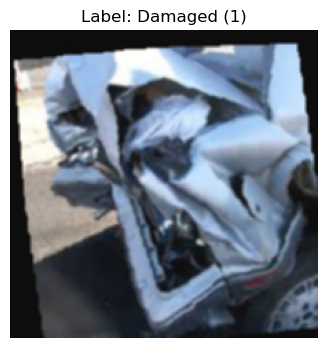

In [7]:
def unnormalize(img_tensor, mean, std):
    """
    img_tensor: Tensor (C, H, W)
    """
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return img_tensor * std + mean

# Get one batch
images, labels = next(iter(train_loader))

# Select one image
img = images[0]
label = labels[0].item()

# Unnormalize
img = unnormalize(
    img,
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

# Convert to HWC for matplotlib
img = img.permute(1, 2, 0).clamp(0, 1)

# Label mapping (adjust if needed)
label_map = {
    0: "Undamaged",
    1: "Damaged"
}

plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.title(f"Label: {label_map[label]} ({label})")
plt.axis("off")
plt.show()


# Initiate the Resnet model class

In [8]:
class Model(torch.nn.Module):
    def __init__(self, dropout1=0.3, dropout2=0.4, dropout3=0.5, out1=1024, out2=512, out3=256):
        super().__init__()

        self.extractor = models.resnet50(pretrained=True)
        in_features = self.extractor.fc.in_features # Extract only the vector feature importance
        self.extractor.fc = torch.nn.Identity()
        
        self.mlp_layer = torch.nn.Sequential(
            torch.nn.Linear(in_features=in_features, out_features=out1),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout1),

            torch.nn.Linear(in_features=out1, out_features=out2),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout2),

            torch.nn.Linear(in_features=out2, out_features=out3),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout3),
        )
        
        self.classifier_head = torch.nn.Linear(in_features=out3, out_features=CONFIG['NUM_CLASSES'])

    def forward(self, x):
        img_features = self.extractor(x)
        mlp_features = self.mlp_layer(img_features)
        prediction = self.classifier_head(mlp_features)

        return prediction

# Handling class imbalance and customise weight on loss function

In [9]:
def compute_class_weights(loader, num_classes, device):
    print(f"Computing class weight...\n")
    counts = Counter()

    for _, labels in tqdm(loader, desc=f"Loading the labels"):
        counts.update(labels.tolist())

    total = sum(counts.values())

    # weight = total / class_count
    weights = torch.tensor(
        [total / counts[i] for i in range(num_classes)],
        dtype=torch.float32,
        device=device
    )

    print("\nClass Weights:")
    for i, cls in enumerate(CONFIG['CLASS_NAME']):
        print(f"{cls}: {weights[i].item():.4f}   (count = {counts[i]})")

    return weights

In [10]:
class_weights = compute_class_weights(train_loader, CONFIG['NUM_CLASSES'], CONFIG['DEVICE'])

Computing class weight...



Loading the labels: 100%|██████████| 101/101 [00:11<00:00,  8.70it/s]


Class Weights:
damaged: 2.0125   (count = 800)
undamaged: 1.9877   (count = 810)


# Hyperparameterization process

In [11]:
X_train, y_train = [], []

for inputs, labels in train_loader:
    X_train.append(inputs)
    y_train.append(labels)

# Concatenate all batches into single tensors
X_train = torch.cat(X_train)
y_train = torch.cat(y_train)

X_train = X_train.numpy()
y_train = y_train.numpy()

print(X_train.shape, y_train.shape)

(1610, 3, 224, 224) (1610,)


In [12]:
model_net = NeuralNetClassifier(
    Model,
    max_epochs=5,
    lr=CONFIG['LR'],
    optimizer = torch.optim.Adam,
    criterion = torch.nn.CrossEntropyLoss,
    train_split= skorch.dataset.ValidSplit(0.2),
    callbacks=[skorch.callbacks.GradientNormClipping(5.0)],
    device = CONFIG['DEVICE']
)

In [13]:
params = {
    "module__out1": [512, 1024],
    "module__out2": [256, 512],
    "module__out3": [128, 256],

    "module__dropout1": [0.2, 0.3, 0.4],
    "module__dropout2": [0.3, 0.4, 0.5],
    "module__dropout3": [0.4, 0.5],

    "lr": loguniform(1e-4, 1e-2),
    'max_epochs': randint(5, 61),
}

In [14]:
scorer = make_scorer(score_func=accuracy_score, greater_is_better=True)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [15]:
search = RandomizedSearchCV(
    estimator=model_net,
    param_distributions=params,
    n_iter=5,
    scoring=scorer,
    cv=cv,
    verbose=2,
    random_state=42
)

search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5843       0.7519        0.5202  4.9003
      2        0.2428       0.5310       20.1542  4.1034
      3        0.2326       0.7287        3.5921  4.0813
      4        0.1949       0.8643        0.7064  4.0765
      5        0.0687       0.8682        0.5712  4.0740
      6        0.0355       0.8217        0.9540  4.0769
      7        0.0579       0.8411        0.7917  4.0818
      8        0.0359       0.8488        0.6407  4.0762
      9        0.0608       0.7636        1.5326  4.0808
     10        0.0468       0.8140        1.2045  4.0781
     11        0.0384       0.8101        0.9248  4.0809
     12        0.0131       0.8721        0.5429  4.0779
     13        0.0115       0.8798        0.6967  4.0784
     14        0.0194       0.8372        1.0037  4.0745
     15        0.0140       

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","<class 'skorc...n__.Model'>, )"
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'lr': <scipy.stats....001B101462FD0>, 'max_epochs': <scipy.stats....001B10145FB90>, 'module__dropout1': [0.2, 0.3, ...], 'module__dropout2': [0.3, 0.4, ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",5
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",make_scorer(a...hod='predict')
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the v

In [16]:
print("Best parameters found:")
print(search.best_params_)

print("Best CV accuracy:")
print(search.best_score_)

Best parameters found:
{'lr': np.float64(0.00010035927878780911), 'max_epochs': 25, 'module__dropout1': 0.2, 'module__dropout2': 0.4, 'module__dropout3': 0.5, 'module__out1': 512, 'module__out2': 512, 'module__out3': 128}
Best CV accuracy:
0.912422360248447


# Initiate the training and validation phase

In [17]:
best_params = search.best_params_

In [18]:
model = Model(
    out1=best_params['module__out1'],
    out2=best_params['module__out2'],
    out3=best_params['module__out3'],
    dropout1=best_params['module__dropout1'],
    dropout2=best_params['module__dropout2'],
    dropout3=best_params['module__dropout3']
).to(CONFIG['DEVICE'])

train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

best_val_loss = np.inf
epochs_no_improve = 0
best_model_state = None
best_val_acc = np.inf

loss_func = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(params=model.parameters(), lr=best_params['lr'], weight_decay=CONFIG['WEIGHT_DECAY'])

In [19]:
for epoch in range(best_params['max_epochs']):
    print(f"\nEpoch {epoch+1}/{best_params['max_epochs']}")

    # Training loop
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Training {epoch + 1}"):
        images = images.to(CONFIG['DEVICE'])
        labels = labels.to(CONFIG['DEVICE'])

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Validation loop
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Validation {epoch + 1}"):
            images = images.to(CONFIG['DEVICE'])
            labels = labels.to(CONFIG['DEVICE'])

            outputs = model(images)
            loss = loss_func(outputs, labels)

            running_val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = running_val_loss / len(val_loader)
    val_acc = correct / total

    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(
        f"Epoch [{epoch+1}/{best_params['max_epochs']}] | "
        f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
    )

    # early stopping mechanism
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_val_acc = val_acc
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        print(f"Validation loss did not improve ({epochs_no_improve}/{CONFIG['PATIENCE']})")

        if epochs_no_improve >= CONFIG['PATIENCE']:
            print("\nEarly stopping triggered.")
            break

# restore the best model weights
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Best model weights restored.")

print("\n🎉 Training finished!")
print("Best validation accuracy:", val_acc)



Epoch 1/25


Validation 1: 100%|██████████| 29/29 [00:02<00:00, 12.65it/s]


Epoch [1/25] | Train Loss: 0.4320 | Train Acc: 0.8311 | Val Loss: 0.5159 | Val Acc: 0.7957

Epoch 2/25


Validation 2: 100%|██████████| 29/29 [00:02<00:00, 14.16it/s]


Epoch [2/25] | Train Loss: 0.2833 | Train Acc: 0.8938 | Val Loss: 0.1953 | Val Acc: 0.9261

Epoch 3/25


Validation 3: 100%|██████████| 29/29 [00:02<00:00, 14.17it/s]


Epoch [3/25] | Train Loss: 0.2257 | Train Acc: 0.9137 | Val Loss: 0.2581 | Val Acc: 0.8870
Validation loss did not improve (1/5)

Epoch 4/25


Validation 4: 100%|██████████| 29/29 [00:02<00:00, 14.02it/s]


Epoch [4/25] | Train Loss: 0.1935 | Train Acc: 0.9311 | Val Loss: 0.1887 | Val Acc: 0.9348

Epoch 5/25


Validation 5: 100%|██████████| 29/29 [00:02<00:00, 14.35it/s]


Epoch [5/25] | Train Loss: 0.2117 | Train Acc: 0.9205 | Val Loss: 0.2350 | Val Acc: 0.9196
Validation loss did not improve (1/5)

Epoch 6/25


Validation 6: 100%|██████████| 29/29 [00:02<00:00, 14.36it/s]


Epoch [6/25] | Train Loss: 0.1929 | Train Acc: 0.9404 | Val Loss: 0.2261 | Val Acc: 0.9065
Validation loss did not improve (2/5)

Epoch 7/25


Validation 7: 100%|██████████| 29/29 [00:02<00:00, 14.38it/s]


Epoch [7/25] | Train Loss: 0.1766 | Train Acc: 0.9329 | Val Loss: 0.2508 | Val Acc: 0.9043
Validation loss did not improve (3/5)

Epoch 8/25


Validation 8: 100%|██████████| 29/29 [00:02<00:00, 14.33it/s]


Epoch [8/25] | Train Loss: 0.1563 | Train Acc: 0.9460 | Val Loss: 0.2913 | Val Acc: 0.8957
Validation loss did not improve (4/5)

Epoch 9/25


Validation 9: 100%|██████████| 29/29 [00:02<00:00, 14.37it/s]

Epoch [9/25] | Train Loss: 0.1463 | Train Acc: 0.9491 | Val Loss: 0.2069 | Val Acc: 0.9239
Validation loss did not improve (5/5)

Early stopping triggered.
Best model weights restored.

🎉 Training finished!
Best validation accuracy: 0.9239130434782609


# Model Evaluation

In [20]:
test_loss_sum = 0
total = 0
correct = 0
all_preds = []
all_labels = []
all_probs = []

model.eval()

with torch.no_grad():
    test_pbar = tqdm(test_loader, desc=f"Validating...")
    for img, label in test_pbar:
        X = img.to(CONFIG['DEVICE'])
        y = label.to(CONFIG['DEVICE'])

        outputs = model(X)

        loss = loss_func(outputs, y)
        test_loss_sum += loss.item()

        probs = torch.softmax(outputs, dim=1)
        preds = probs.argmax(dim=1)

        correct += (preds == y).sum().item()
        total += y.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

epoch_test_loss = test_loss_sum / len(test_loader)
epoch_test_acc = correct / total

print(f"Loss: {epoch_test_loss}")
print(f"Accuracy: {epoch_test_acc}")

Validating...: 100%|██████████| 15/15 [00:01<00:00, 14.82it/s]

Loss: 0.23770281175772348
Accuracy: 0.9130434782608695


In [21]:
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=CONFIG['CLASS_NAME'], digits=4))


Classification Report:

              precision    recall  f1-score   support

     damaged     0.9271    0.8725    0.8990       102
   undamaged     0.9030    0.9453    0.9237       128

    accuracy                         0.9130       230
   macro avg     0.9150    0.9089    0.9113       230
weighted avg     0.9137    0.9130    0.9127       230



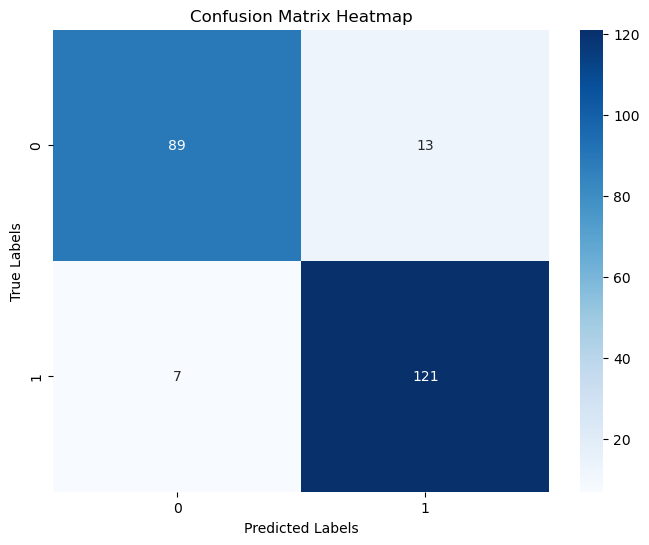

In [22]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=range(len(set(all_labels))),
            yticklabels=range(len(set(all_labels))))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [23]:
cm_df = pd.DataFrame(cm, index=CONFIG['CLASS_NAME'], columns=CONFIG['CLASS_NAME'])
print("\nConfusion Matrix:\n")
print(cm_df)


Confusion Matrix:

           damaged  undamaged
damaged         89         13
undamaged        7        121


In [24]:
y_true = np.array(all_labels)
y_prob = np.array(all_probs)

n_classes = len(CONFIG['CLASS_NAME'])
y_true_bin = label_binarize(y_true, classes=range(n_classes))

In [28]:
print("y_true shape:", y_true.shape)
print("y_prob shape:", y_prob.shape)
print("unique y_true:", np.unique(y_true))

y_true shape: (230,)
y_prob shape: (230, 2)
unique y_true: [0 1]


In [32]:
# Positive class probability (class 1)
y_score = y_prob[:, 1]

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# ROC-AUC score (binary)
roc_auc_score_value = roc_auc_score(y_true, y_score)

print("\nROC-AUC Scores:")
print(f"{CONFIG['CLASS_NAME'][1]} vs rest: {roc_auc_score_value:.4f}")


ROC-AUC Scores:
undamaged vs rest: 0.9705


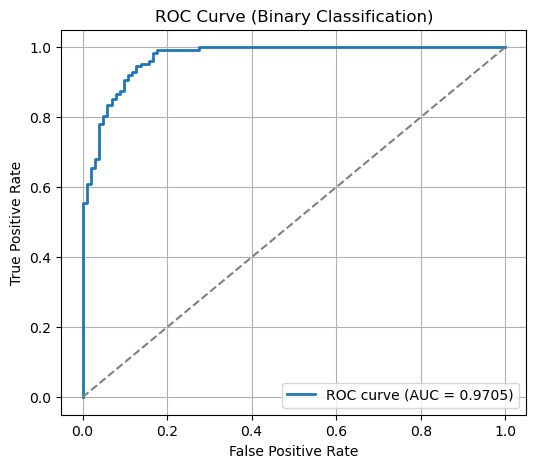

In [33]:
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Binary Classification)")
plt.legend()
plt.grid(True)
plt.show()

In [34]:
# Positive class probability (class 1)
y_score = y_prob[:, 1]

# Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_score)

# Average Precision (PR-AUC)
avg_precision = average_precision_score(y_true, y_score)

print("\nPR-AUC Scores:")
print(f"{CONFIG['CLASS_NAME'][1]} vs rest: {avg_precision:.4f}")


PR-AUC Scores:
undamaged vs rest: 0.9749


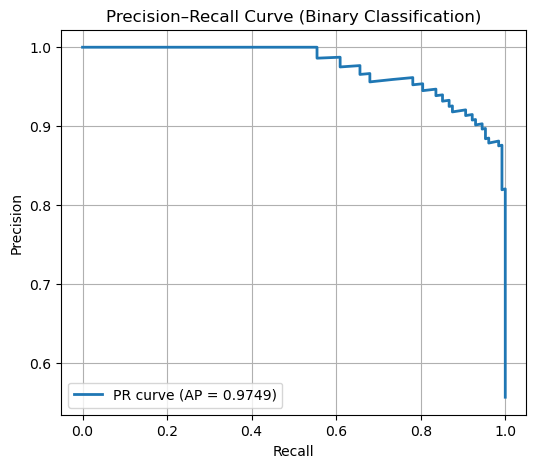

In [35]:
plt.figure(figsize=(6, 5))
plt.plot(
    recall,
    precision,
    label=f"PR curve (AP = {avg_precision:.4f})",
    linewidth=2
)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Binary Classification)")
plt.legend()
plt.grid(True)
plt.show()

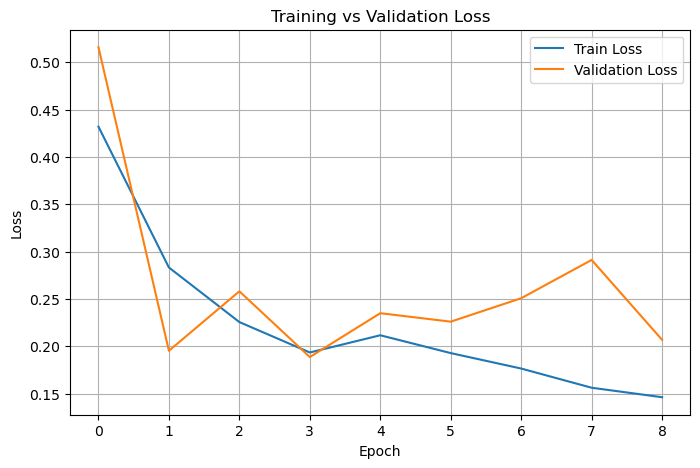

In [40]:
epochs = range(len(train_loss_history))

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss_history, label="Train Loss")
plt.plot(epochs, val_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

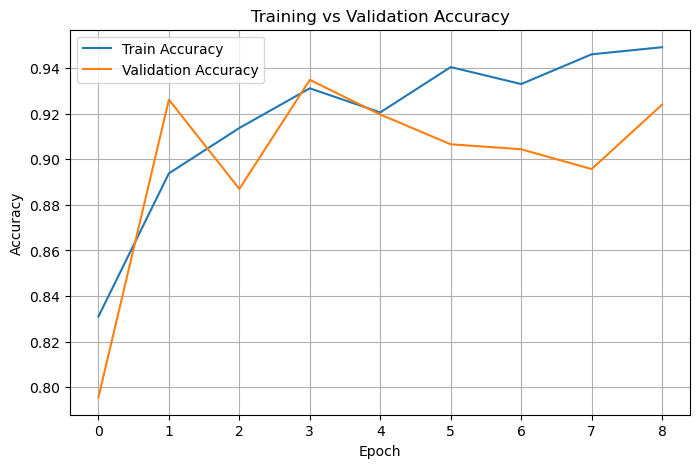

In [41]:
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_acc_history, label="Train Accuracy")
plt.plot(epochs, val_acc_history, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Save the model

In [46]:
model_architecture = {
    'state_dict': model.state_dict(),
    'config': {
        'dropout1' : best_params['module__dropout1'],
        'dropout2' : best_params['module__dropout2'],
        'dropout3' : best_params['module__dropout3'],
        'out1' : best_params['module__out1'],
        'out2' : best_params['module__out2'],
        'out3' : best_params['module__out3']
    }
}

torch.save(model_architecture, CONFIG['MODEL_PATH'])